In [0]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
# tensorflow
import tflearn
from tflearn.data_utils import to_categorical, pad_sequences
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [31]:
import pickle
df = pd.read_pickle('ign_dataset.pkl')
df.shape

(18622, 2)

In [32]:
df.head()

,score_phrase,text
0,Amazing,LittleBigPlanet PS Vita PlayStation Vita Platf...
1,Amazing,LittleBigPlanet PS Vita -- Marvel Super Hero E...
2,Great,Splice: Tree of Life iPad Puzzle N
3,Great,NHL 13 Xbox 360 Sports N
4,Great,NHL 13 PlayStation 3 Sports N


In [33]:
df.score_phrase.value_counts()

Great          4773
Good           4741
Okay           2945
Mediocre       1959
Amazing        1804
Bad            1269
Awful           664
Painful         340
Unbearable       72
Masterpiece      55
Name: score_phrase, dtype: int64

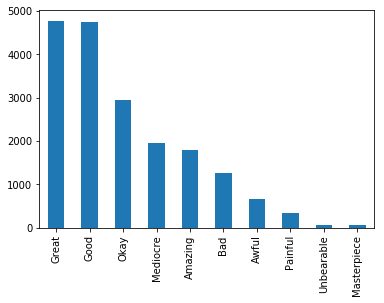

In [34]:
df.score_phrase.value_counts().plot(kind='bar')

In [0]:
X = df.text
y = df.score_phrase

In [36]:
print(X.shape)
print(y.shape)

(18622,)
(18622,)


In [0]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X)

In [38]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1298,70,3,70,25,4
1,0,0,0,0,0,0,0,0,0,0,1298,70,242,47,95,35,3,70,25,4
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1753,10,187,116,21,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,93,692,8,16,9,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,93,692,3,12,9,1


In [39]:
X.shape

(18622, 20)

### Train-Test data split

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2019)

In [41]:
X_train.shape, X_test.shape

((13966, 20), (4656, 20))

In [42]:
print(y_train.shape)
print(y_test.shape)

(13966,)
(4656,)


### Encoding y-variable

In [43]:
unique_y_labels = list(y_train.value_counts().index)
unique_y_labels

['Great',
 'Good',
 'Okay',
 'Mediocre',
 'Amazing',
 'Bad',
 'Awful',
 'Painful',
 'Unbearable',
 'Masterpiece']

In [44]:
len(unique_y_labels)

10

In [45]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(unique_y_labels)

LabelEncoder()

In [46]:
print('')
for label_id, label_name in zip(le.transform(unique_y_labels), unique_y_labels):
    print('%d: %s' % (label_id, label_name))
print('')


4: Great
3: Good
7: Okay
6: Mediocre
0: Amazing
2: Bad
1: Awful
8: Painful
9: Unbearable
5: Masterpiece



In [47]:
print(y_train.shape)
print(y_test.shape)

(13966,)
(4656,)


In [0]:
# keras needs inputs to be vectors , so one hot encoding values
from keras.utils import np_utils
def one_hot_encode_object_array(arr):
    '''One hot encode a numpy array of objects (e.g. strings)'''
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))

y_train_ohe=one_hot_encode_object_array(y_train)
y_test_ohe=one_hot_encode_object_array(y_test)

In [49]:
y_train[:5]

12179    Great
17284    Great
573      Great
18403     Good
1359     Great
Name: score_phrase, dtype: object

In [50]:
y_train_ohe[:5]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

## Build LSTM model

In [0]:
embed_dim = 128
lstm_out = 196
max_fatures = 2000

In [0]:
size_of_each_vector = X_train.shape[1]
no_of_unique_y_labels = len(unique_y_labels)

In [54]:
print('size_of_each_vector:', size_of_each_vector)
print('no_of_unique_y_labels:', no_of_unique_y_labels)

size_of_each_vector: 20
no_of_unique_y_labels: 10


In [55]:
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = size_of_each_vector))
# X.shape[1] refers to 20 columns 
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(no_of_unique_y_labels,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 128)           256000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 20, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1970      
Total params: 512,770
Trainable params: 512,770
Non-trainable params: 0
_________________________________________________________________
None


### Train model

In [0]:
batch_size = 32
epochs = 20

In [0]:
from keras.callbacks import EarlyStopping

In [58]:
history = model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Instructions for updating:
Use tf.cast instead.
Train on 12569 samples, validate on 1397 samples
Epoch 1/20
12569/12569 [==============================] - 19s 2ms/step - loss: 1.6308 - acc: 0.3468 - val_loss: 1.5542 - val_acc: 0.3672
Epoch 2/20
12569/12569 [==============================] - 17s 1ms/step - loss: 1.5105 - acc: 0.3879 - val_loss: 1.5255 - val_acc: 0.3916
Epoch 3/20
12569/12569 [==============================] - 17s 1ms/step - loss: 1.4501 - acc: 0.4180 - val_loss: 1.4938 - val_acc: 0.4080
Epoch 4/20
12569/12569 [==============================] - 17s 1ms/step - loss: 1.4018 - acc: 0.4388 - val_loss: 1.5052 - val_acc: 0.3973
Epoch 5/20
12569/12569 [==============================] - 17s 1ms/step - loss: 1.3651 - acc: 0.4583 - val_loss: 1.5179 - val_acc: 0.4094
Epoch 6/20
12569/12569 [==============================] - 17s 1ms/step - loss: 1.3303 - acc: 0.4755 - val_loss: 1.5124 - val_acc: 0.4059


# Evaluate the model

In [0]:
y_pred = model.predict(X_test)

In [60]:
y_pred[:5]

array([[6.08693226e-04, 4.03385656e-03, 1.90988649e-02, 7.29081452e-01,
        5.56561537e-02, 8.74249054e-06, 3.97060215e-02, 1.48809671e-01,
        2.72752927e-03, 2.68999051e-04],
       [1.95536036e-02, 2.89761946e-02, 3.80581431e-02, 3.57075125e-01,
        3.52310121e-01, 5.33248007e-04, 6.12471402e-02, 1.23648934e-01,
        1.35599952e-02, 5.03747771e-03],
       [2.77449749e-03, 4.76673283e-02, 1.32764593e-01, 2.08213314e-01,
        1.36758670e-01, 1.80461488e-04, 1.53484076e-01, 2.86025554e-01,
        2.82419045e-02, 3.88959423e-03],
       [2.41424912e-03, 8.61252248e-02, 2.26129919e-01, 1.78438157e-01,
        6.22038208e-02, 2.86814146e-04, 2.02582598e-01, 1.90153614e-01,
        4.71212827e-02, 4.54436149e-03],
       [1.15652906e-03, 5.66186570e-02, 1.50590897e-01, 2.49148980e-01,
        8.58213454e-02, 9.73608549e-05, 1.61051124e-01, 2.51547933e-01,
        3.83285433e-02, 5.63867670e-03]], dtype=float32)

In [61]:
y_test_ohe[:5]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [0]:
## predict crisp classes for test set. Output will be 1-D
y_test_class = np.argmax(y_test_ohe,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

In [63]:
y_test_class[:5]

array([6, 7, 4, 3, 2])

In [64]:
y_pred_class[:5]

array([3, 3, 7, 2, 7])

### Classification Report

In [65]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.66      0.51      0.57       438
           1       0.23      0.02      0.03       170
           2       0.20      0.16      0.18       322
           3       0.38      0.73      0.50      1220
           4       0.49      0.52      0.51      1166
           5       0.50      0.08      0.13        13
           6       0.34      0.09      0.14       476
           7       0.33      0.15      0.21       732
           8       1.00      0.02      0.04        99
           9       0.00      0.00      0.00        20

    accuracy                           0.41      4656
   macro avg       0.41      0.23      0.23      4656
weighted avg       0.42      0.41      0.37      4656



### Confusion matrix

In [66]:
print(confusion_matrix(y_test_class,y_pred_class))

[[223   1   0  14 199   0   0   1   0   0]
 [  0   3  31  90  21   0   6  19   0   0]
 [  0   1  51 179  30   0  21  40   0   0]
 [  0   2  43 888 192   0  19  76   0   0]
 [107   1  18 384 611   1   4  40   0   0]
 [ 10   0   0   1   1   1   0   0   0   0]
 [  0   2  49 282  62   0  41  40   0   0]
 [  0   0  43 448 107   0  24 110   0   0]
 [  0   3  14  57  10   0   4   9   2   0]
 [  0   0   2  15   3   0   0   0   0   0]]


### Loss and accuracy

In [67]:
loss, accuracy = model.evaluate(X_train, y_train_ohe, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))

Training Accuracy: 0.5033
Training Loss: 1.2785


In [68]:
loss, accuracy = model.evaluate(X_test, y_test_ohe, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Loss:  {:.4f}".format(loss))

Testing Accuracy:  0.4145
Testing Loss:  1.4999


In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

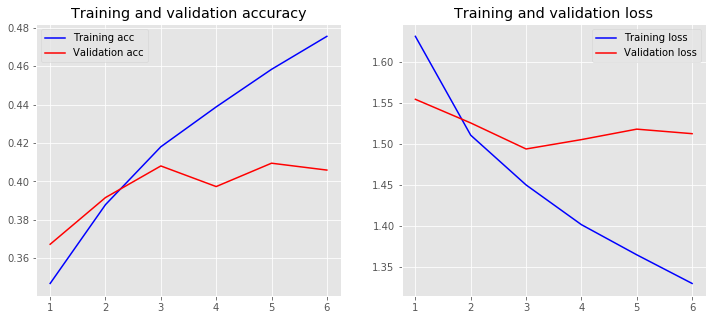

In [70]:
plot_history(history)